# 🌱🛰️ Field Spectral Index Analysis

## Overview

This notebook analyzes field health and irrigation needs using spectral indices from satellite imagery.

**Key Metrics:**
- **NDVI** (Normalized Difference Vegetation Index): Measures vegetation health (0-1 scale)
- **NDMI** (Normalized Difference Moisture Index): Measures water content and soil moisture (0-1 scale)

**Data Source:** STAC API querying processed field data from Dagster pipeline partitions.


## Setup


In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

API_URL = "http://localhost:8000"


## Load Data


In [2]:
# Load data
response = requests.get(f'{API_URL}/collections/field-indices/items', params={'limit': 1000})
items = response.json()['features']

# Extract NDVI and NDMI separately
ndvi = [{'field_id': i['properties']['field_id'], 'plant_type': i['properties']['plant_type'], 
         'date': i['properties']['datetime'][:10], 'ndvi_mean': i['properties']['ndvi_mean']}
        for i in items if i['properties']['index_type'] == 'NDVI']
ndmi = [{'field_id': i['properties']['field_id'], 'plant_type': i['properties']['plant_type'], 
         'date': i['properties']['datetime'][:10], 'ndmi_mean': i['properties']['ndmi_mean']}
        for i in items if i['properties']['index_type'] == 'NDMI']

# Merge NDVI and NDMI
merged = pd.merge(pd.DataFrame(ndvi), pd.DataFrame(ndmi), on=['field_id', 'plant_type', 'date'], how='outer')
merged['date'] = pd.to_datetime(merged['date'])

print(f'Loaded {len(merged)} observations')
merged.head()


Loaded 30 observations


,field_id,plant_type,date,ndvi_mean,ndmi_mean
0,field_1,Winter Lettuce (Iceberg or Romaine),2025-10-11,0.339507,-0.039729
1,field_1,Winter Lettuce (Iceberg or Romaine),2025-10-16,0.339549,-0.025795
2,field_1,Winter Lettuce (Iceberg or Romaine),2025-10-18,0.333012,-0.029404
3,field_1,Winter Lettuce (Iceberg or Romaine),2025-10-26,0.327931,-0.034851
4,field_1,Winter Lettuce (Iceberg or Romaine),2025-10-31,0.310148,-0.036493


## 🌾 Analysis 2: Crop Readiness Assessment

**Criteria**: High NDVI indicates mature vegetation, declining NDVI may indicate harvest time.

For harvest timing:
- **Peak NDVI** indicates maximum growth/maturity
- **Declining NDVI** after peak may indicate senescence (ready for harvest)
- **Low NDMI** with moderate NDVI can indicate crop maturity


## 📈 Analysis 3: Time Series Visualization

Visualize NDVI and NDMI trends over time for each field.


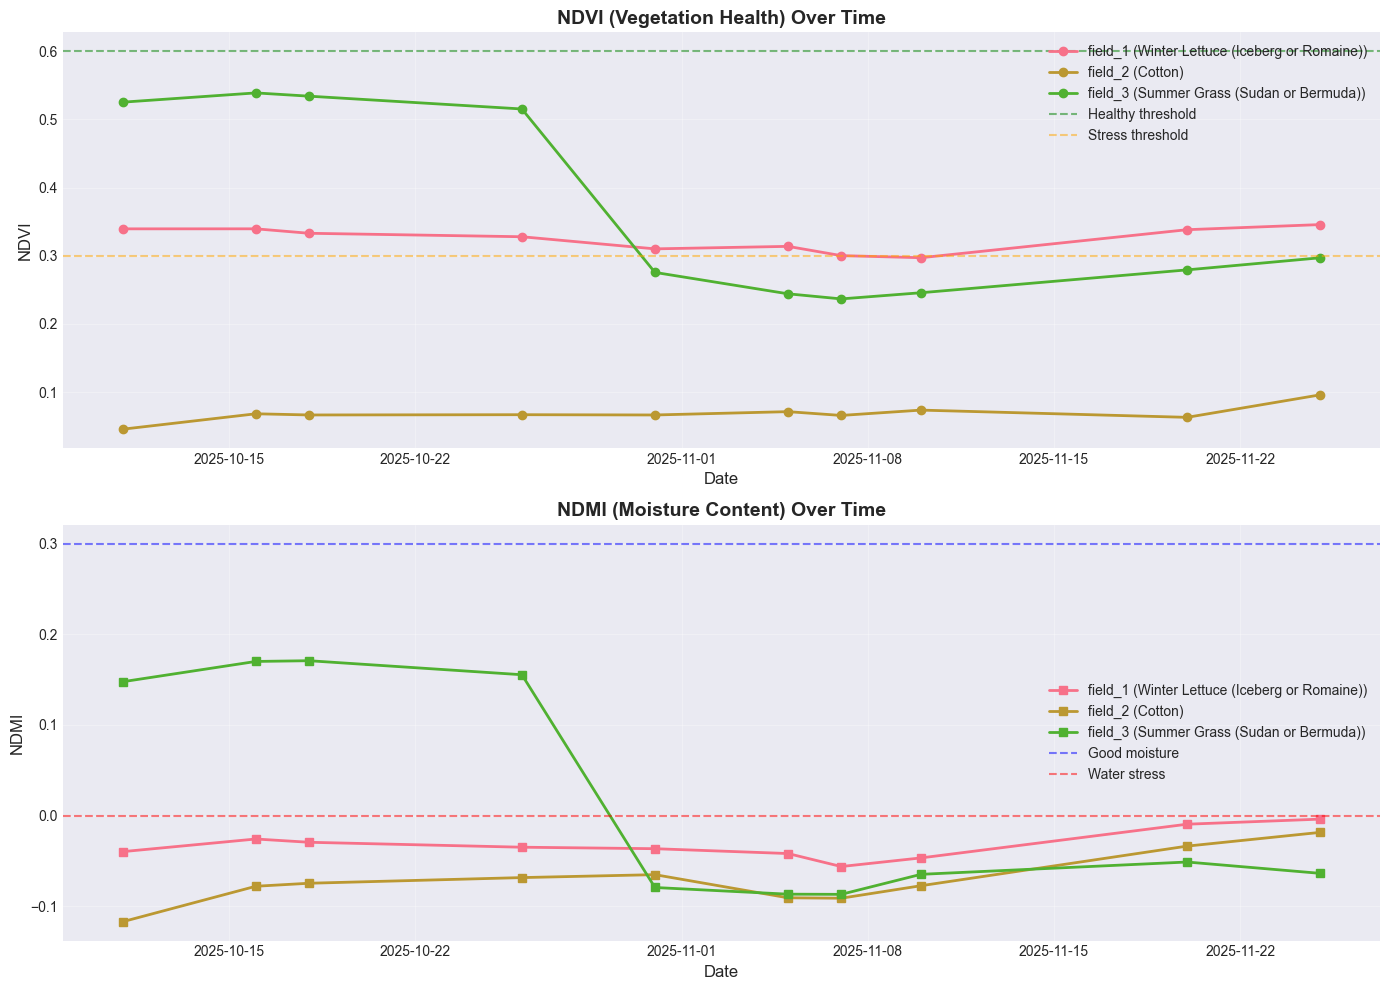

In [3]:
# Create time series plots
merged['date'] = pd.to_datetime(merged['date'])

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# NDVI over time
for field_id in merged['field_id'].unique():
    field_data = merged[merged['field_id'] == field_id].sort_values('date')
    plant_type = field_data['plant_type'].iloc[0]
    axes[0].plot(field_data['date'], field_data['ndvi_mean'], 
                 marker='o', label=f"{field_id} ({plant_type})", linewidth=2)

axes[0].set_title('NDVI (Vegetation Health) Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('NDVI', fontsize=12)
axes[0].axhline(y=0.6, color='green', linestyle='--', alpha=0.5, label='Healthy threshold')
axes[0].axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, label='Stress threshold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# NDMI over time
for field_id in merged['field_id'].unique():
    field_data = merged[merged['field_id'] == field_id].sort_values('date')
    plant_type = field_data['plant_type'].iloc[0]
    axes[1].plot(field_data['date'], field_data['ndmi_mean'], 
                 marker='s', label=f"{field_id} ({plant_type})", linewidth=2)

axes[1].set_title('NDMI (Moisture Content) Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('NDMI', fontsize=12)
axes[1].axhline(y=0.3, color='blue', linestyle='--', alpha=0.5, label='Good moisture')
axes[1].axhline(y=0.0, color='red', linestyle='--', alpha=0.5, label='Water stress')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 🎯 Analysis 4: Field Health Status

Classify fields into health categories based on current NDVI and NDMI values.


## NDVI vs NDMI Scatter Plot


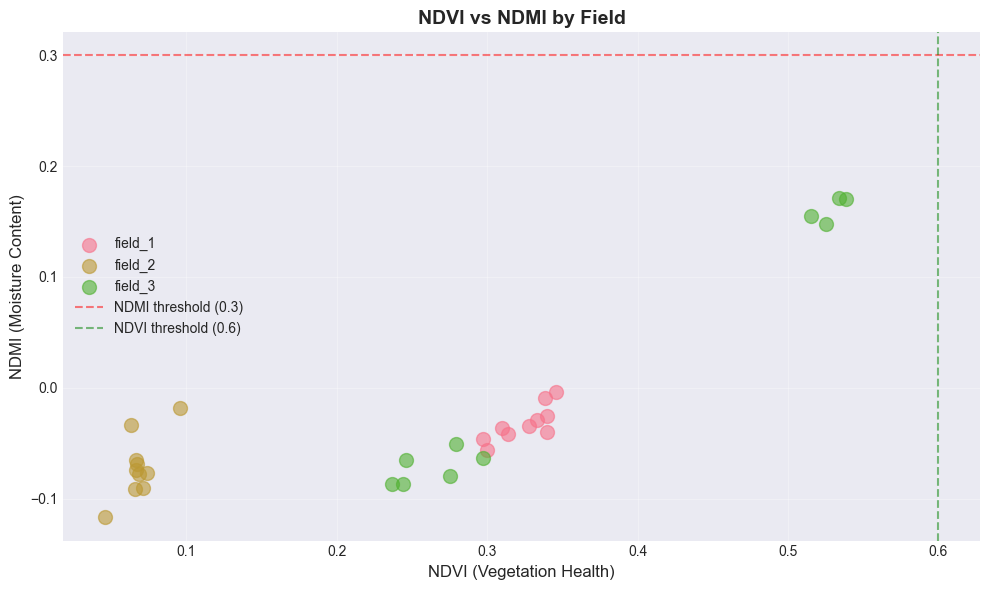

In [4]:
# Scatter plot: NDVI vs NDMI colored by field
plt.figure(figsize=(10, 6))
for field_id in sorted(merged['field_id'].unique()):
    data = merged[merged['field_id'] == field_id]
    plt.scatter(data['ndvi_mean'], data['ndmi_mean'], label=field_id, alpha=0.6, s=100)

plt.axhline(y=0.3, color='r', linestyle='--', alpha=0.5, label='NDMI threshold (0.3)')
plt.axvline(x=0.6, color='g', linestyle='--', alpha=0.5, label='NDVI threshold (0.6)')
plt.xlabel('NDVI (Vegetation Health)', fontsize=12)
plt.ylabel('NDMI (Moisture Content)', fontsize=12)
plt.title('NDVI vs NDMI by Field', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Heatmap: Field Health Over Time


In [7]:
def classify_field_health(ndvi, ndmi):
    """Classify field health based on NDVI and NDMI values."""
    if pd.isna(ndvi) or pd.isna(ndmi):
        return "Unknown", "⚪", "Insufficient data"
    
    # Critical: Needs immediate attention
    if ndmi < 0.0 and ndvi > 0.4:
        return "Critical - Water Stress", "🔴", "High vegetation, very low moisture - Irrigate immediately!"
    
    # Warning: Needs water soon
    if ndmi < 0.3 and ndvi > 0.3:
        return "Warning - Low Moisture", "🟡", "Vegetation present but moisture low - Plan irrigation"
    
    # Healthy: Good condition
    if ndvi > 0.5 and ndmi > 0.2:
        return "Healthy", "🟢", "Good vegetation and moisture levels"
    
    # Moderate: Monitor
    if 0.3 < ndvi < 0.5:
        return "Moderate", "🟠", "Moderate vegetation - Monitor closely"
    
    # Poor: Stressed or bare
    if ndvi < 0.3:
        return "Poor - Stressed", "🔵", "Low vegetation - May need intervention beyond irrigation"
    
    return "Stable", "⚪", "Stable condition"

# Get latest observation for each field
latest_observations = merged.sort_values('date').groupby('field_id').last().reset_index()

# Show actual NDVI/NDMI values for diagnosis
print("📊 Actual NDVI/NDMI Values (Latest Observation):")
print("=" * 70)
for idx, row in latest_observations.iterrows():
    ndvi = row['ndvi_mean']
    ndmi = row['ndmi_mean']
    print(f"{row['field_id']} ({row['plant_type']}):")
    print(f"  NDVI: {ndvi:.3f} {'✅' if pd.notna(ndvi) and ndvi > 0.5 else '❌ (needs > 0.5 for healthy)'}")
    print(f"  NDMI: {ndmi:.3f} {'✅' if pd.notna(ndmi) and ndmi > 0.2 else '❌ (needs > 0.2 for healthy)'}")
    print(f"  Date: {row['date']}")
    print()

# Classify health
latest_observations['health_status'], latest_observations['emoji'], latest_observations['recommendation'] = \
    zip(*latest_observations.apply(lambda row: classify_field_health(row['ndvi_mean'], row['ndmi_mean']), axis=1))

print("🏥 Current Field Health Status")
print("=" * 70)
print("Note: 'Healthy' requires BOTH NDVI > 0.5 AND NDMI > 0.2")
print()
display(latest_observations[['emoji', 'field_id', 'plant_type', 'health_status', 'ndvi_mean', 'ndmi_mean', 'recommendation']].sort_values('health_status'))

# Count by status
print("\n📊 Health Status Summary")
print("=" * 70)
status_counts = latest_observations['health_status'].value_counts()
for status, count in status_counts.items():
    emoji = latest_observations[latest_observations['health_status'] == status]['emoji'].iloc[0]
    print(f"{emoji} {status}: {count} field(s)")

# Explain why no fields are healthy
print("\n💡 Why No Fields Are 'Healthy':")
print("=" * 70)
healthy_count = len(latest_observations[
    (latest_observations['ndvi_mean'] > 0.5) & 
    (latest_observations['ndmi_mean'] > 0.2)
])
print(f"Fields meeting BOTH criteria (NDVI > 0.5 AND NDMI > 0.2): {healthy_count}")
print()
print("Breakdown:")
ndvi_high = len(latest_observations[latest_observations['ndvi_mean'] > 0.5])
ndmi_high = len(latest_observations[latest_observations['ndmi_mean'] > 0.2])
print(f"  - Fields with NDVI > 0.5: {ndvi_high}")
print(f"  - Fields with NDMI > 0.2: {ndmi_high}")
print(f"  - Fields with BOTH: {healthy_count}")
print()
print("Possible reasons:")
print("  1. Early growth stage - crops may not have reached full vegetation yet")
print("  2. Low moisture - fields may need irrigation")
print("  3. Crop type - some crops naturally have lower NDVI values")
print("  4. Seasonal factors - time of year affects vegetation growth")
print("  5. Data quality - cloud cover or processing issues may affect values")


📊 Actual NDVI/NDMI Values (Latest Observation):
field_1 (Winter Lettuce (Iceberg or Romaine)):
  NDVI: 0.346 ❌ (needs > 0.5 for healthy)
  NDMI: -0.004 ❌ (needs > 0.2 for healthy)
  Date: 2025-11-25 00:00:00

field_2 (Cotton):
  NDVI: 0.096 ❌ (needs > 0.5 for healthy)
  NDMI: -0.018 ❌ (needs > 0.2 for healthy)
  Date: 2025-11-25 00:00:00

field_3 (Summer Grass (Sudan or Bermuda)):
  NDVI: 0.297 ❌ (needs > 0.5 for healthy)
  NDMI: -0.064 ❌ (needs > 0.2 for healthy)
  Date: 2025-11-25 00:00:00

🏥 Current Field Health Status
Note: 'Healthy' requires BOTH NDVI > 0.5 AND NDMI > 0.2



,emoji,field_id,plant_type,health_status,ndvi_mean,ndmi_mean,recommendation
1,🔵,field_2,Cotton,Poor - Stressed,0.096036,-0.018490,Low vegetation - May need intervention beyond ...
2,🔵,field_3,Summer Grass (Sudan or Bermuda),Poor - Stressed,0.297060,-0.063685,Low vegetation - May need intervention beyond ...
0,🟡,field_1,Winter Lettuce (Iceberg or Romaine),Warning - Low Moisture,0.345749,-0.003872,Vegetation present but moisture low - Plan irr...



📊 Health Status Summary
🔵 Poor - Stressed: 2 field(s)
🟡 Warning - Low Moisture: 1 field(s)

💡 Why No Fields Are 'Healthy':
Fields meeting BOTH criteria (NDVI > 0.5 AND NDMI > 0.2): 0

Breakdown:
  - Fields with NDVI > 0.5: 0
  - Fields with NDMI > 0.2: 0
  - Fields with BOTH: 0

Possible reasons:
  1. Early growth stage - crops may not have reached full vegetation yet
  2. Low moisture - fields may need irrigation
  3. Crop type - some crops naturally have lower NDVI values
  4. Seasonal factors - time of year affects vegetation growth
  5. Data quality - cloud cover or processing issues may affect values
